<img src="https://raw.githubusercontent.com/StanfordSocialNeuroscienceLab/json-parser/main/.images/SSNL.jpg" width=75%>




# fMRI Processing Pipeline

## Single-Subject Object Demo

In [1]:
# Imports
import os, warnings, json
warnings.filterwarnings('ignore')

from nilearn import image
import nilearn.plotting as nip

try:
    os.chdir('/Users/ianferguson/Box Sync/Research/SCP/0-fMRI/Ian-NiPype')
except:
    os.chdir('/Users/IanFerguson 1/Box Sync/Research/SCP/0-fMRI/Ian-NiPype')

----------

### Instantiating an SCP_Sub object

In [2]:
from communities import SCP_Sub
sub = SCP_Sub('01024', 'stressbuffer', suppress=False)

{
    "Subject ID": "01024",
    "Task": "stressbuffer",
    "# of Functional Runs": 3,
    "Functional Runs": [
        "./bids/sub-01024/func/sub-01024_task-stressbuffer_run-1_bold.nii.gz",
        "./bids/sub-01024/func/sub-01024_task-stressbuffer_run-2_bold.nii.gz",
        "./bids/sub-01024/func/sub-01024_task-stressbuffer_run-3_bold.nii.gz"
    ],
    "Path to Output Directory": "./bids/derivatives/first-level/sub-01024/task-stressbuffer"
}


The `SCP_Sub` object interacts directly with an external JSON file `./task_information.json`, which allows you to easily modify various components of your first-level model estimation. The `SCP_Sub` object implicitly reads the task information file when itialized:

In [3]:
sub._taskfile_validator()

{'conditions': ['self', 'low_trust', 'high_trust'],
 'confound_regressors': ['framewise_displacement',
  'dvars',
  'csf',
  'trans_x',
  'trans_y',
  'trans_z',
  'rot_x',
  'rot_y',
  'rot_z',
  'white_matter'],
 'network_regressors': ['indegree_CloseFrds_fa18'],
 'block_regressors': ['fixation',
  'memory',
  'perspective',
  'valence',
  'arousal',
  'spatial'],
 'trial_type': 'block_type',
 'tr': 1.0,
 'excludes': ['01022', '02013', '05021', '05032', '05036'],
 'design-contrasts': {'highlow_v_self': '(high_trust_perspective + low_trust_perspective) - self_perspective',
  'perspective_high_self': 'high_trust_perspective - self_perspective',
  'perspective_low_self': 'low_trust_perspective - self_perspective',
  'perspective_high_low': 'high_trust_perspective - low_trust_perspective',
  'memory_perspective_self': 'self_memory - self_perspective',
  'memory_perspective_high': 'high_trust_memory - high_trust_perspective',
  'memory_perspective_low': 'low_trust_memory - low_trust_persp

In [4]:
sub.conditions

['self', 'low_trust', 'high_trust']

The task information file contains fields for **confound** and **network** regressors

* **Confound regressors** are derived from fmriprep, and correct for in-scanner artifacts, motion, CSF, and the like
    * Our `SCP_Sub` object reads these in from the confounds CSV located under `derivatives/fmriprep/{sub-id}`
    
    
* We define **network regressors** as personality covariates derived from the Stanford Communities Project. This allows us to factor various network traits (e.g., network centrality) into our models - for example, the popularity of a target that a participant might see in one of the functional tasks

In [5]:
sub.confound_regressors

['framewise_displacement',
 'dvars',
 'csf',
 'trans_x',
 'trans_y',
 'trans_z',
 'rot_x',
 'rot_y',
 'rot_z',
 'white_matter']

In [6]:
sub.network_regressors

['indegree_CloseFrds_fa18']

You have the option to either define your contrasts a priori, or let the `SCP_Sub` object do it for you. When you leave the contrasts field of the task information file empty, the `_default_contrasts()` function will simply loop through your defined conditions and compute pairwise contrasts (e.g., dorm - nondorm, dorm - attention, attention - nondorm)

In [7]:
# Pre-defined contrasts
sub.contrasts

{'highlow_v_self': '(high_trust_perspective + low_trust_perspective) - self_perspective',
 'perspective_high_self': 'high_trust_perspective - self_perspective',
 'perspective_low_self': 'low_trust_perspective - self_perspective',
 'perspective_high_low': 'high_trust_perspective - low_trust_perspective',
 'memory_perspective_self': 'self_memory - self_perspective',
 'memory_perspective_high': 'high_trust_memory - high_trust_perspective',
 'memory_perspective_low': 'low_trust_memory - low_trust_perspective',
 'active_baseline_self': 'self_memory - self_spatial',
 'active_baseline_high_trust': 'high_trust_memory - high_trust_spatial',
 'active_baseline_low_trust': 'low_trust_memory - low_trust_spatial'}

In [8]:
# Contrasts defined by the script
sub._default_contrasts()

{'self-low_trust': 'self-low_trust',
 'self-high_trust': 'self-high_trust',
 'low_trust-self': 'low_trust-self',
 'low_trust-high_trust': 'low_trust-high_trust',
 'high_trust-self': 'high_trust-self',
 'high_trust-low_trust': 'high_trust-low_trust'}

In the spirit of data organization, this object implicitly organizes the outputs of your modeling into task-specific directories under the derivatives folder in your BIDS project. Z-maps are saved as `.nii.gz` files and plots of each condtion map and contrast map are saved automatically

In [9]:
%%bash
tree ./bids/derivatives/first-level/sub-01024/task-stressbuffer/

./bids/derivatives/first-level/sub-01024/task-stressbuffer/
├── first-level-model
│   ├── condition-maps
│   │   ├── sub-01024_condition-high_trust_arousal_z-map.nii.gz
│   │   ├── sub-01024_condition-high_trust_memory_z-map.nii.gz
│   │   ├── sub-01024_condition-high_trust_perspective_z-map.nii.gz
│   │   ├── sub-01024_condition-high_trust_spatial_z-map.nii.gz
│   │   ├── sub-01024_condition-high_trust_valence_z-map.nii.gz
│   │   ├── sub-01024_condition-low_trust_arousal_z-map.nii.gz
│   │   ├── sub-01024_condition-low_trust_memory_z-map.nii.gz
│   │   ├── sub-01024_condition-low_trust_perspective_z-map.nii.gz
│   │   ├── sub-01024_condition-low_trust_spatial_z-map.nii.gz
│   │   ├── sub-01024_condition-low_trust_valence_z-map.nii.gz
│   │   ├── sub-01024_condition-self_arousal_z-map.nii.gz
│   │   ├── sub-01024_condition-self_memory_z-map.nii.gz
│   │   ├── sub-01024_condition-self_perspective_z-map.nii.gz
│   │   ├── sub-01024_condition-self_spatial_z-map.nii.gz
│   │   └── sub-010

In [10]:
sub.nilearn_first_level_condition

'./bids/derivatives/first-level/sub-01024/task-stressbuffer/first-level-model/condition-maps'

---------

### GLM Estimation

We achieve first-level model estimation in two steps:

* Run-wise design matrices are computed using one of two functions
    * Event-design tasks utilize the `.firstLevel_event_design()` function
    * Block-design tasks utilize the `.firstLevel_block_design()` function
    * To maximize contrast flexibility, block design tasks pair up the block and task into a new regressor in the design matrix - e.g., high_trust_perspective, high_trust_valence, low_trust_perspective, low_trust_valence
    
    
* The design function returns a list of design matrices, which are then fed into a Nilearn `FirstLevelModel` object


* The model is run and contrasts are automatically computed (see above)


* The resulting output is then saved in the directory hierarchy outlined earlier

In [11]:
dm = sub.firstLevel_block_design()

dm[0]

,high_trust_arousal,high_trust_memory,high_trust_perspective,high_trust_spatial,high_trust_valence,low_trust_arousal,low_trust_memory,low_trust_perspective,low_trust_spatial,low_trust_valence,...,trans_z,rot_x,rot_y,rot_z,white_matter,indegree_CloseFrds_fa18,drift_1,drift_2,drift_3,constant
0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,-0.000913,-0.006883,-0.001432,0.001320,13488.587541,0.0,-0.500000,0.165929,-0.049338,1.0
1.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,-0.130020,-0.009705,-0.003071,0.002027,13510.395892,0.0,-0.495575,0.161524,-0.046719,1.0
2.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,-0.109701,-0.009648,-0.002817,0.001673,13514.430828,0.0,-0.491150,0.157158,-0.044157,1.0
3.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,-0.100282,-0.009643,-0.002817,0.001815,13519.497259,0.0,-0.486726,0.152831,-0.041653,1.0
4.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,-0.100237,-0.009583,-0.002566,0.001511,13525.123143,0.0,-0.482301,0.148543,-0.039207,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222.0,-0.006275,0.0,0.0,-0.048543,-0.000528,0.0,0.0,0.0,0.0,0.0,...,-0.053881,-0.007603,-0.002356,0.001569,13487.229255,2.0,0.482301,0.148543,0.039207,1.0
223.0,-0.004103,0.0,0.0,-0.104743,-0.000260,0.0,0.0,0.0,0.0,0.0,...,-0.071137,-0.008531,-0.002153,0.001277,13494.531447,2.0,0.486726,0.152831,0.041653,1.0
224.0,-0.002628,0.0,0.0,-0.133618,-0.000097,0.0,0.0,0.0,0.0,0.0,...,-0.042411,-0.008547,-0.002333,0.001173,13493.325604,2.0,0.491150,0.157158,0.044157,1.0
225.0,-0.001651,0.0,0.0,-0.143046,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000987,-0.008335,-0.002429,0.001511,13506.734322,2.0,0.495575,0.161524,0.046719,1.0


<AxesSubplot:label='conditions', ylabel='scan number'>

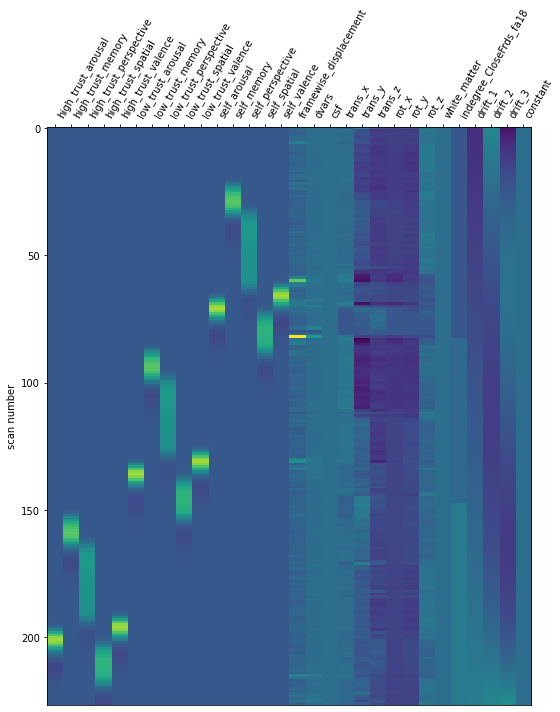

In [12]:
nip.plot_design_matrix(dm[0])

In [13]:
sub.firstLevel_contrasts(conditions=False)


--------- Fitting model, please hold...


  0%|                                                                                                                                             | 0/10 [00:00<?, ?it/s]


--------- Mapping contrast z-scores



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [08:19<00:00, 49.94s/it]


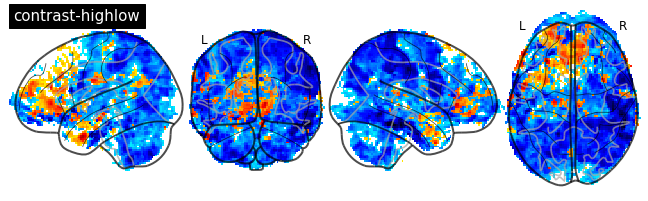

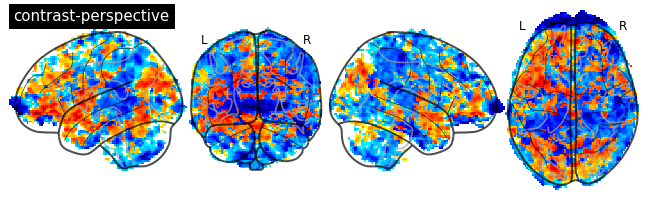

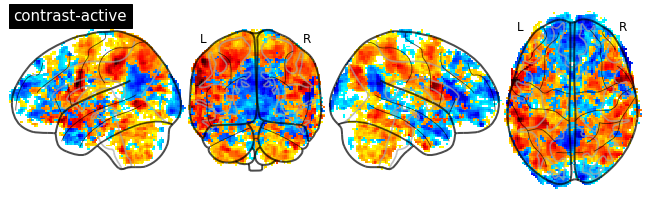

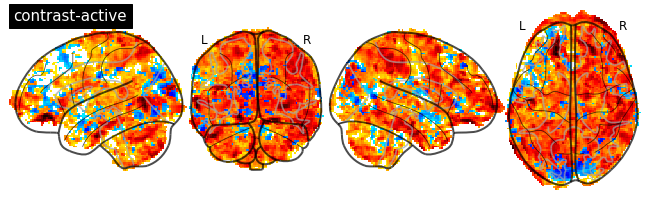

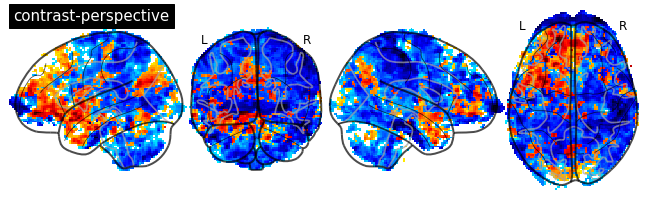

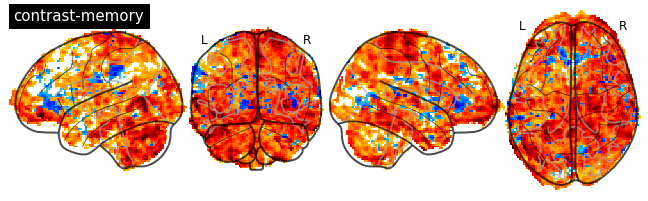

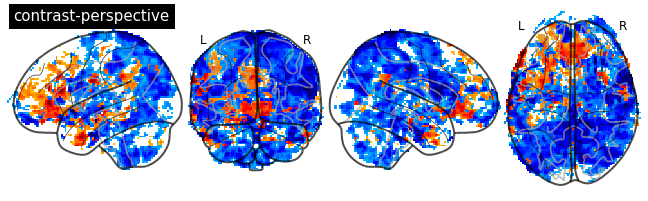

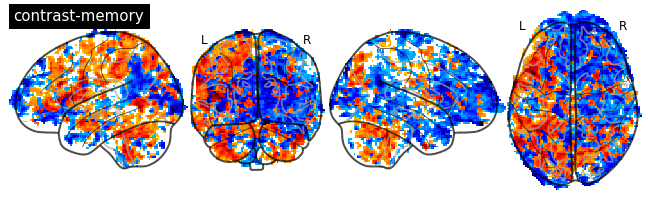

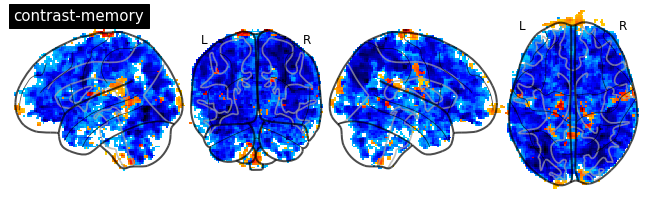

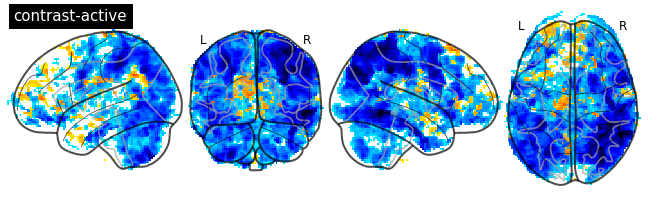

In [14]:
for z_map in os.listdir(sub.nilearn_first_level_contrasts):
    z = image.load_img(os.path.join(sub.nilearn_first_level_contrasts, z_map))
    title = z_map.split('/')[-1].split('_')[1]
    
    nip.plot_glass_brain(z, title=title, threshold=2.3, plot_abs=False, colorbar=False, display_mode='lyrz')

--------